In [4]:
import warnings

# Suppressen warnings tf, wanneer een gpu gebruikt wordt op in production kunnen deze zaken geïnstalleerd worden
warnings.filterwarnings("ignore", category=Warning, message=".*cuDNN.*")
warnings.filterwarnings("ignore", category=Warning, message=".*cuFFT.*")
warnings.filterwarnings("ignore", category=Warning, message=".*cuBLAS.*")
warnings.filterwarnings("ignore", category=Warning, message=".*TF-TRT.*")

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# wanneer google colab gebruiken, uit comments halen
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# DATADIR = r"/content/drive/MyDrive/covers"  # Path naar data op google drive
# DATADIR = r"C:\covers\covers"  # Path naar data lokaal
DATADIR = '/mnt/c/covers/covers'  # Path naar data met WSL2

img_height, img_width = 224, 224
batch_size=8
# Larger batch size may provide some computational speed-up but requires more memory
# Smaller batch sizes may offer better generalization, but training might be slower

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATADIR,
  validation_split=0.20,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )

In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATADIR,
  validation_split=0.20,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )

Found 9863 files belonging to 2 classes.
Using 1972 files for validation.


In [9]:
from collections import Counter
import tensorflow as tf

# Counting the labels
label_counts = Counter()
for _, labels in train_ds:
    label_counts.update(labels.numpy())

# Printing out the count of each label
for label, count in label_counts.items():
    print(f"Label {label}: {count} samples")


class_weights = {0: 1.818, 1: 4.0}


print(class_weights)

Label 0: 5420 samples
Label 1: 2471 samples
{0: 1.818, 1: 4.0}


In [10]:
# Define the ModuleWrapper class
class ModuleWrapper(tf.keras.layers.Layer):
    def __init__(self, module, method_name, **kwargs):
        super(ModuleWrapper, self).__init__(**kwargs)
        self.module = module
        self.method_name = method_name

    def call(self, inputs):
        pass

    def get_config(self):
        config = super(ModuleWrapper, self).get_config()
        config.update({
            'module': self.module,
            'method_name': self.method_name
        })
        return config

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomContrast(0.2), 
    layers.RandomBrightness(0.2),
])

In [12]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

In [13]:
resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(img_height, img_width, 3),
    pooling='avg',
    classes=1,
    weights='imagenet'
)

for layer in pretrained_model.layers:
    layer.trainable = False

# resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(512, activation='relu'))
resnet_model.add(layers.Dropout(0.2))
resnet_model.add(layers.Dense(1, activation='sigmoid'))

module_wrapper = ModuleWrapper(pretrained_model, "call")
module_wrapper.build((None, img_height, img_width, 3))

# pretrained_model.summary()

In [14]:
resnet_model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 50

history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights
)


In [16]:
from keras.models import load_model

resnet_model.save('themis.keras')
themis = tf.keras.models.load_model('themis.keras')
print(themis.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24637313 (93.98 MB)
Trainable params: 1049601 (4.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
None


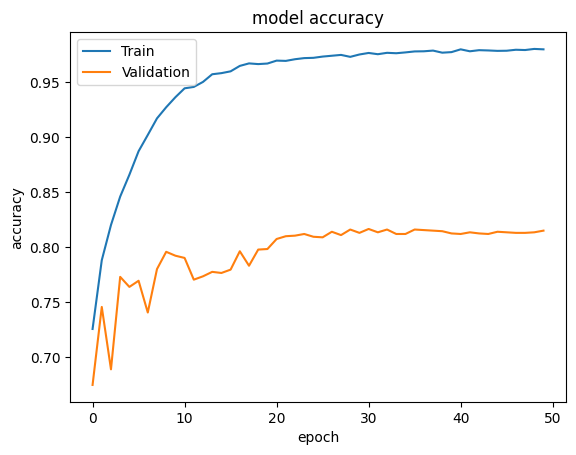

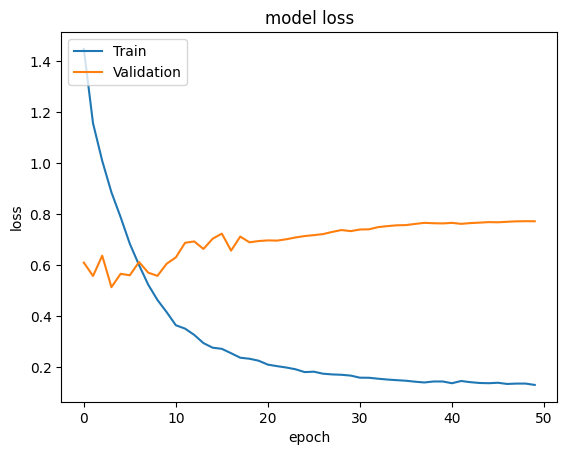

In [17]:
# evaluatie accuracy & loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import cv2
import os
import numpy as np

# Load the model
# resnet_model = tf.keras.models.load_model(r"C:\OwnPorrima\themis_model_v.keras") # local
resnet_model = tf.keras.models.load_model("/mnt/c/OwnPorrima/themis_model_v3.keras") # wsl2

# TEST_DIR = r"C:\covers\testset" # local
TEST_DIR = "/mnt/c/covers/testset" # wsl2

CATEGORIES = ["goed", "slecht"]  # Labels / Subfolders

img_height, img_width = 224, 224 

predictions = []

for category in CATEGORIES:
    path = os.path.join(TEST_DIR, category)

    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        
        img = cv2.imread(img_path)
        img = cv2.resize(img, (img_width, img_height))
        img = np.expand_dims(img, axis=0)  # Add batch dimension

        prediction = resnet_model.predict(img)
        print(prediction)

        predicted_category = "goed" if prediction[0][0] <= 0.5 else "slecht"

        predictions.append((img_path, category, predicted_category))

for img_path, true_category, predicted_category in predictions:
    print(f"Image: {img_path}, True Category: {true_category}, Predicted Category: {predicted_category}")
